# Install Required Libraries

In [1]:
!pip install rasterio albumentations segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00


# Import Libraries

In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import rasterio   # for loading the 12 spectral band images
from PIL import Image
import albumentations as A

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.metrics import MeanIoU

2025-09-24 10:02:22.228834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758708142.563376      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758708142.661103      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
!pip install segmentation-models-tf

ERROR: Could not find a version that satisfies the requirement segmentation-models-tf (from versions: none)
ERROR: No matching distribution found for segmentation-models-tf


In [5]:
print("TF Version: ", tf.__version__)
print("keras version: ", keras.__version__)

TF Version:  2.18.0
keras version:  3.8.0


# Extract Zip File

In [ ]:
# zip_path = '/content/drive/MyDrive/Colab Notebooks/Cellula Tech Intern Computer Vision/Task 3: Satellite Images Flooding Segmentation/satalite data-20250918T154859Z-1-001.zip'
# extract_path = '/content/satellite_dataset/'

In [ ]:
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# Define Paths

In [7]:
data_path = '/kaggle/input/sat-images-water-bodies/satalite data-20250918T154859Z-1-001/satalite data/data'
images_path = os.path.join(data_path, 'images')
labels_path = os.path.join(data_path, 'labels')

# Function to Match Images and Masks

In [8]:
def get_matched_files(images_path, labels_path):
    image_files = [f for f in os.listdir(images_path) if f.endswith('.tif')]
    matched_images = []
    matched_masks = []

    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        mask_file = f"{base_name}.png"
        mask_path = os.path.join(labels_path, mask_file)

        if os.path.exists(mask_path):
            matched_images.append(os.path.join(images_path, img_file))
            matched_masks.append(mask_path)

    return matched_images, matched_masks

In [9]:
matched_images, matched_masks = get_matched_files(images_path, labels_path)
print(f"Found {len(matched_images)} matched pairs.")

Found 306 matched pairs.


# Function to Load Image (Multi-band TIFF)

In [10]:
def load_image(file_path):
    with rasterio.open(file_path) as src:
        image = src.read()  # Shape: (bands, height, width)
        image = np.moveaxis(image, 0, -1)  # Shape: (height, width, bands)
    return image.astype(np.float32)

# Function to Load Mask (Binary PNG)

In [11]:
def load_mask(file_path):
    mask = np.array(Image.open(file_path))
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    mask = (mask > 0).astype(np.float32)  # Ensure binary
    return mask

# Load Dataset

In [12]:
images = []
masks = []

for img_path, mask_path in zip(matched_images, matched_masks):
    img = load_image(img_path)
    msk = load_mask(mask_path)
    if img.shape == (128, 128, 12) and msk.shape == (128, 128, 1):
        images.append(img)
        masks.append(msk)

images = np.array(images)
masks = np.array(masks)

print(f"Loaded {len(images)} images and masks.")

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Loaded 306 images and masks.


# Normalization with Min-Max Scaler (Per Band)

In [13]:
def normalize_images(images):
    normalized_images = np.zeros_like(images)
    for i in range(images.shape[0]):
        for band in range(12):
            scaler = MinMaxScaler()
            band_data = images[i, :, :, band].reshape(-1, 1)
            normalized_band = scaler.fit_transform(band_data).reshape(128, 128)
            normalized_images[i, :, :, band] = normalized_band
    return normalized_images

In [14]:
images = normalize_images(images)

# Compute Class Weights for Imbalance  (added for better results)

In [15]:
def compute_class_weights(masks):
    total_pixels = masks.size
    water_pixels = np.sum(masks)
    non_water_pixels = total_pixels - water_pixels
    if water_pixels == 0 or non_water_pixels == 0:
        return 1.0
    weight_water = total_pixels / (2 * water_pixels)
    weight_non_water = total_pixels / (2 * non_water_pixels)
    return [weight_non_water, weight_water]

class_weights = compute_class_weights(masks)
print(f"Class weights: {class_weights}")

Class weights: [0.6754500931227151, 1.924906624729703]


# Data Augmentation with Albumentations

In [16]:
# def get_augmentation():
#     return A.Compose([
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.RandomRotate90(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
#     ])

In [17]:
def get_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.GridDistortion(distort_limit=(-0.2, 0.2), p=0.5),
        A.ElasticTransform(p=0.5),
    ])

# Function to Apply Augmentation

In [18]:
# def augment_data(images, masks, augmentation):
#     augmented_images = []
#     augmented_masks = []
#     for img, msk in zip(images, masks):
#         augmented = augmentation(image=img, mask=msk)
#         augmented_images.append(augmented['image'])
#         augmented_masks.append(augmented['mask'])
#     return np.array(augmented_images), np.array(augmented_masks)

In [19]:
# augmentation = get_augmentation()
# aug_images, aug_masks = augment_data(images, masks, augmentation)

In [20]:
def augment_data(images, masks, augmentation, num_augs=1):
    augmented_images = []
    augmented_masks = []
    for _ in range(num_augs):
        for img, msk in zip(images, masks):
            augmented = augmentation(image=img, mask=msk)
            augmented_images.append(augmented['image'])
            augmented_masks.append(augmented['mask'])
    return np.array(augmented_images), np.array(augmented_masks)

In [21]:
augmentation = get_augmentation()
aug_images, aug_masks = augment_data(images, masks, augmentation, num_augs=2)  # Double the augmentations

# Combine Original and Augmented Data

In [22]:
all_images = np.concatenate([images, aug_images], axis=0)
all_masks = np.concatenate([masks, aug_masks], axis=0)

# Train-Test Split

In [23]:
## augmentation

X_train, X_test, y_train, y_test = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)

In [24]:
# X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Function to Visualize Random Images in RGB Format

In [25]:
def visualize_random_rgb(images, num_samples=3):
    indices = np.random.choice(len(images), num_samples, replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))

    for idx, ax in zip(indices, axs):
        # Use bands 3 (Red), 2 (Green), 1 (Blue) for RGB approximation
        rgb = images[idx][:, :, [3, 2, 1]]
        rgb = np.clip(rgb, 0, 1)  # Normalize to [0, 1]
        ax.imshow(rgb)
        ax.set_title(f'Image {idx} (RGB approx)')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

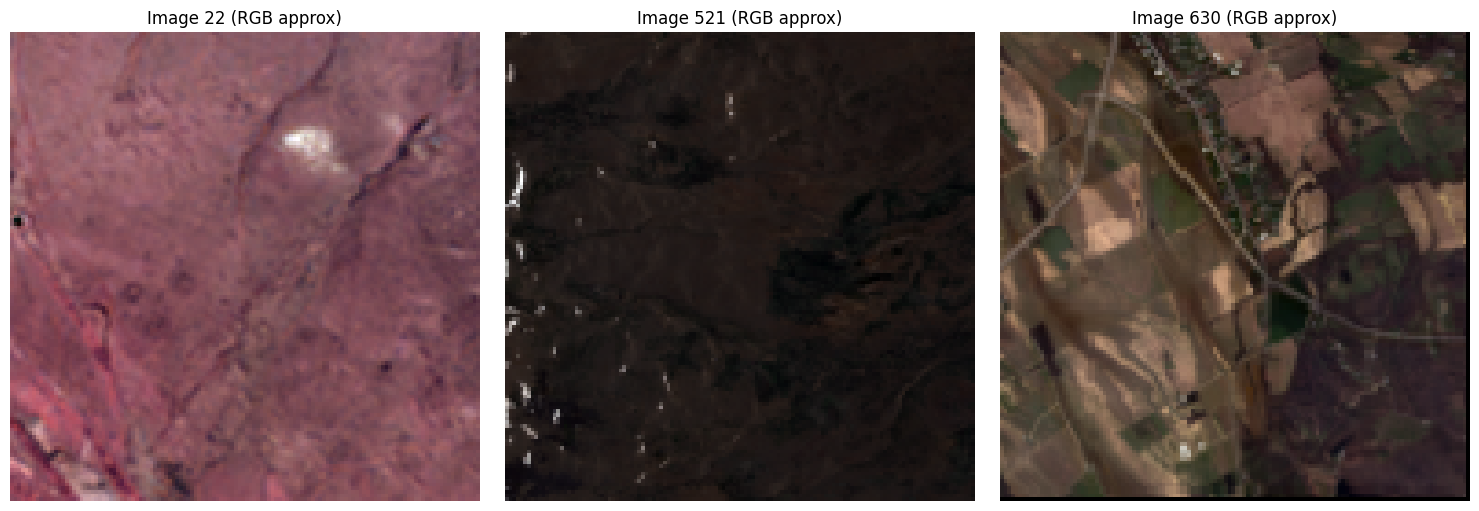

In [26]:
visualize_random_rgb(X_train)

# Visualization: Show Bands of One Image

In [27]:
def visualize_bands(image, band_names=None):
    if band_names is None:
        band_names = [
            'Coastal Aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA Band',
            'Merit DEM', 'Copernicus DEM', 'ESA World Cover', 'Water Occurrence'
        ]

    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    axs = axs.ravel()

    for i in range(12):
        axs[i].imshow(image[:, :, i], cmap='gray')
        axs[i].set_title(band_names[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize first image bands

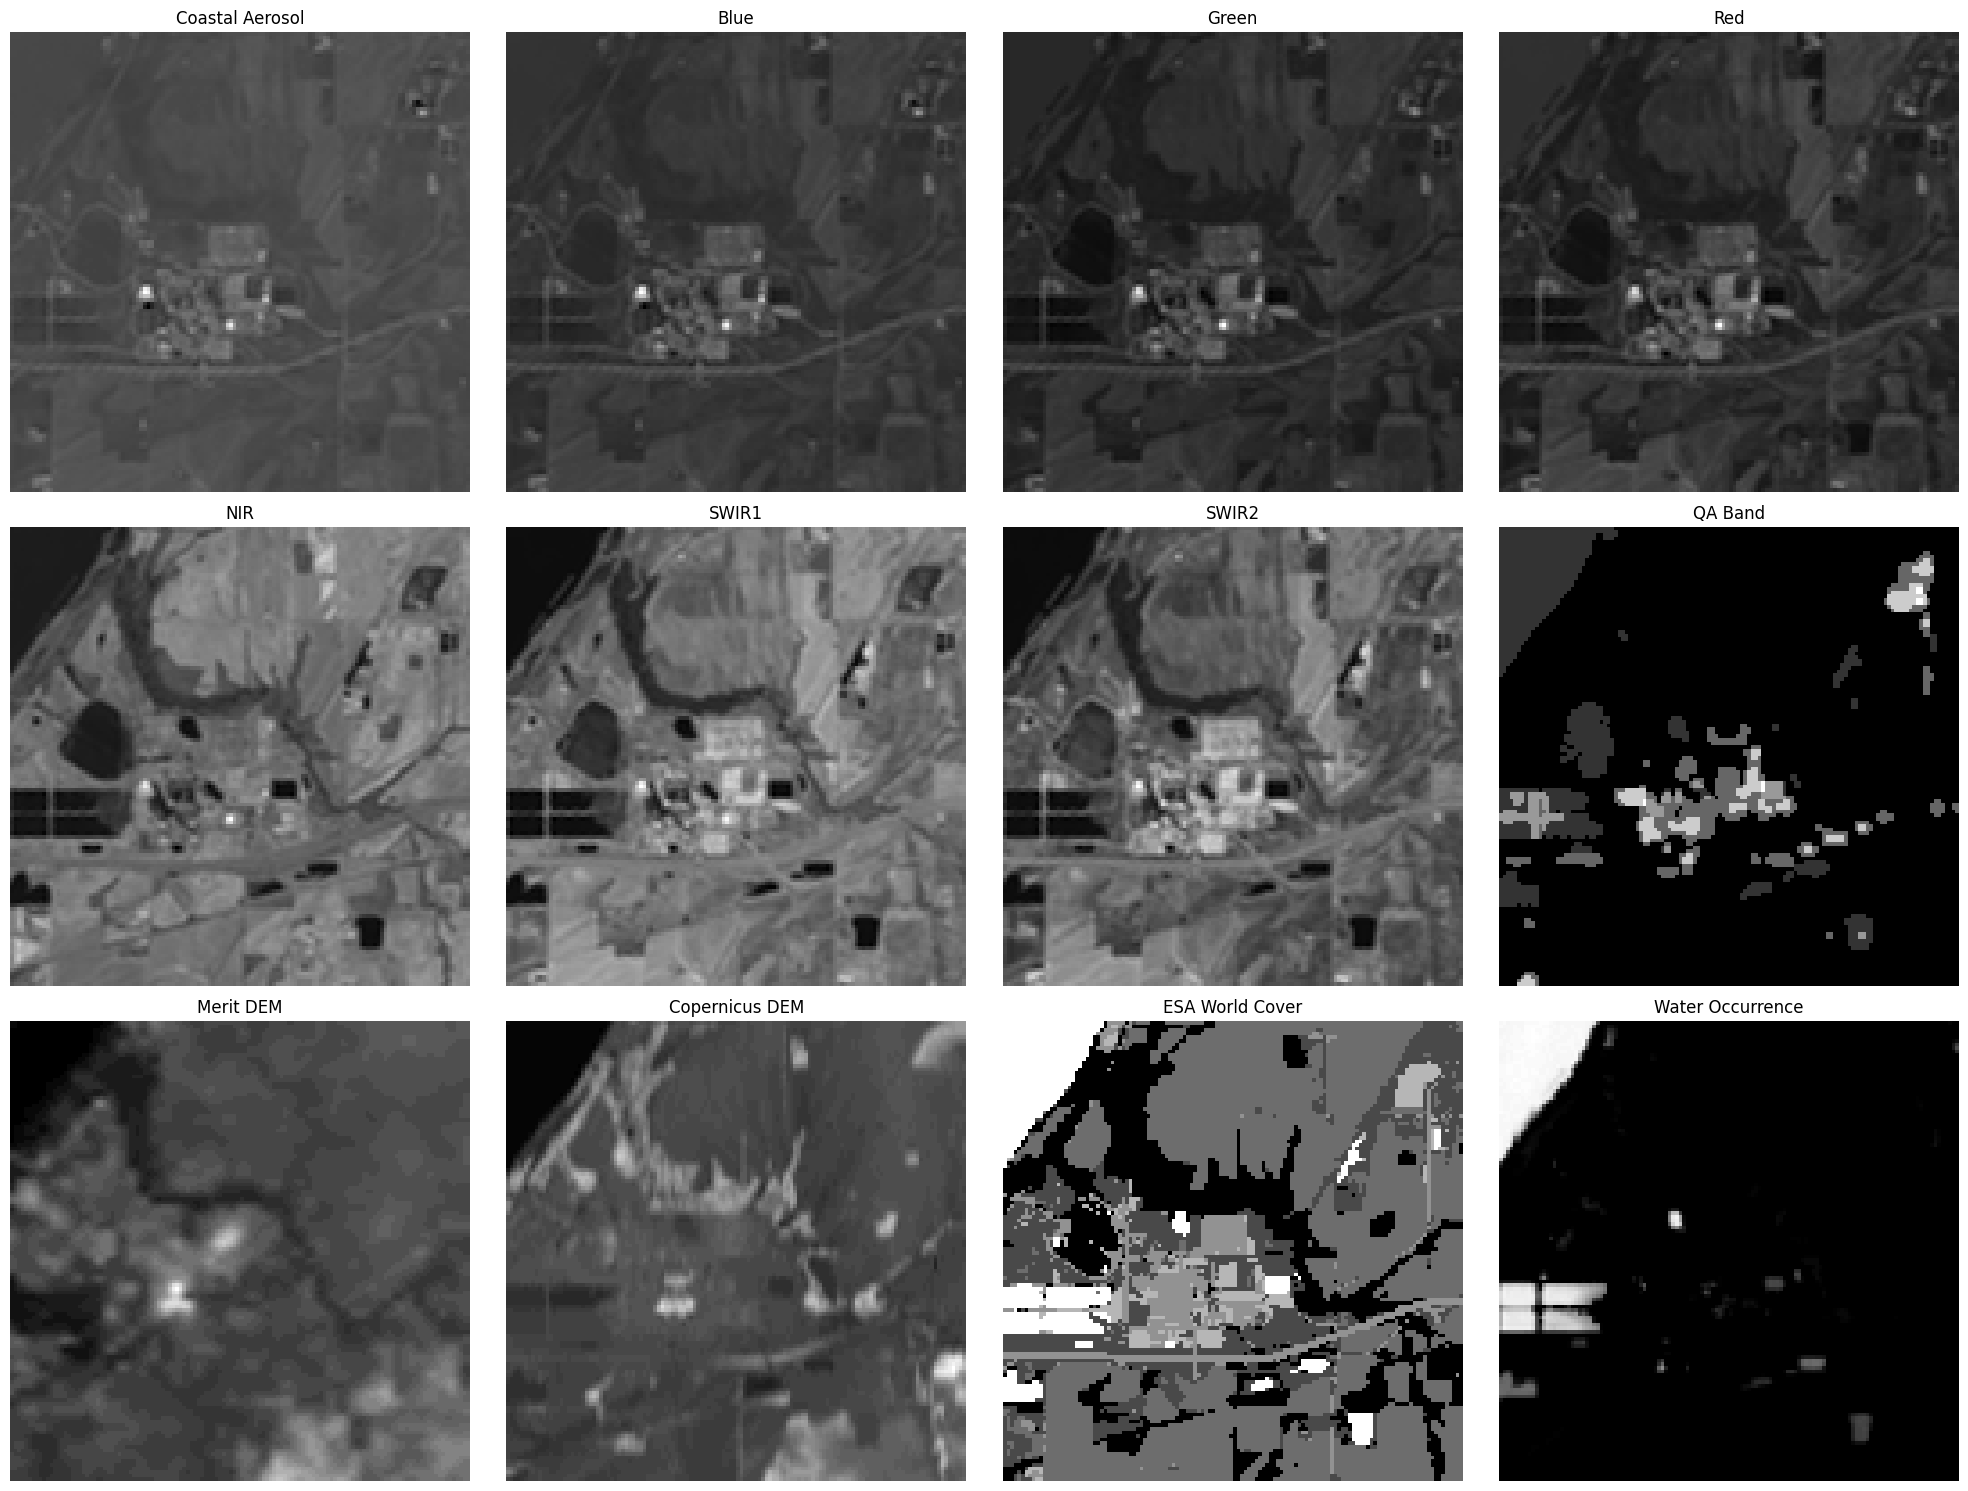

In [28]:
visualize_bands(X_train[0])

# U-Net Model Function

In [29]:
# def unet_model(input_size=(128, 128, 12)):
#     inputs = Input(input_size)

#     # Encoder
#     c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
#     p1 = MaxPooling2D((2, 2))(c1)

#     c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
#     c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
#     p2 = MaxPooling2D((2, 2))(c2)

#     c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
#     c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
#     p3 = MaxPooling2D((2, 2))(c3)

#     c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
#     c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
#     p4 = MaxPooling2D((2, 2))(c4)

#     # bottleneck
#     c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
#     c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

#     # Decoder
#     u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
#     c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

#     u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
#     c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

#     u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
#     c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

#     u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = concatenate([u9, c1])
#     c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
#     c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

#     model = Model(inputs=inputs, outputs=outputs)
#     return model

In [30]:
def unet_model(input_size=(128, 128, 12)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)

    c1 = Conv2D(64, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)

    c1 = Conv2D(64, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)

    p1 = MaxPooling2D((2, 2))(c1)


    c2 = Conv2D(128, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation("relu")(c2)

    c2 = Conv2D(128, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation("relu")(c2)

    c2 = Conv2D(128, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation("relu")(c2)

    p2 = MaxPooling2D((2, 2))(c2)


    c3 = Conv2D(256, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation("relu")(c3)

    c3 = Conv2D(256, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation("relu")(c3)

    c3 = Conv2D(256, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation("relu")(c3)

    p3 = MaxPooling2D((2, 2))(c3)


    c4 = Conv2D(512, (3, 3), padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation("relu")(c4)

    c4 = Conv2D(512, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation("relu")(c4)

    c4 = Conv2D(512, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation("relu")(c4)

    p4 = MaxPooling2D((2, 2))(c4)


    # Bottleneck
    c5 = Conv2D(1024, (3, 3), padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation("relu")(c5)

    c5 = Conv2D(1024, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation("relu")(c5)

    c5 = Conv2D(1024, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation("relu")(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])

    c6 = Conv2D(512, (3, 3), padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation("relu")(c6)

    c6 = Conv2D(512, (3, 3), padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation("relu")(c6)

    c6 = Conv2D(512, (3, 3), padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation("relu")(c6)


    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])

    c7 = Conv2D(256, (3, 3), padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation("relu")(c7)

    c7 = Conv2D(256, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation("relu")(c7)

    c7 = Conv2D(256, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation("relu")(c7)


    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])

    c8 = Conv2D(128, (3, 3), padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation("relu")(c8)

    c8 = Conv2D(128, (3, 3), padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation("relu")(c8)

    c8 = Conv2D(128, (3, 3), padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation("relu")(c8)


    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])

    c9 = Conv2D(64, (3, 3), padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation("relu")(c9)

    c9 = Conv2D(64, (3, 3), padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation("relu")(c9)

    c9 = Conv2D(64, (3, 3), padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation("relu")(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and Compile Model

In [31]:
nn_model = unet_model(input_size=(128, 128, 12))
nn_model.summary()

I0000 00:00:1758708209.494042      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758708209.494668      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 46,779,265 (178.45 MB)

 Trainable params: 46,761,601 (178.38 MB)

 Non-trainable params: 17,664 (69.00 KB)

## Functions to optimize model compilation

In [32]:
def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(tf.maximum(y_true_f, y_pred_f))

    # Compute IoU
    iou = (intersection + smooth) / (union + smooth)

    return iou

In [33]:
# Custom metric for Keras
def iou_metric(y_true, y_pred):
    return tf.reduce_mean(iou_score(y_true, y_pred))

In [34]:
## old function

# def iou_metric(y_true, y_pred, threshold=0.5):
#     # y_true, y_pred are tensors (batch, H, W, 1)
#     y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
#     y_true = tf.cast(y_true, tf.float32)
#     intersection = tf.reduce_sum(y_true * y_pred_bin, axis=[1,2,3])
#     union = tf.reduce_sum(y_true + y_pred_bin - y_true * y_pred_bin, axis=[1,2,3])
#     iou = (intersection + 1e-7) / (union + 1e-7)
#     return tf.reduce_mean(iou)

In [35]:
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    smooth = 1e-6  # Small constant to prevent division by zero
    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - dice

In [36]:
# dice_loss = dice_loss()

In [37]:
# def weighted_dice_loss(y_true, y_pred, class_weights):
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(y_pred, tf.float32)

#     # Flatten the tensors
#     y_true_f = tf.reshape(y_true, [-1])
#     y_pred_f = tf.reshape(y_pred, [-1])

#     # Calculate intersection and union
#     intersection = tf.reduce_sum(y_true_f * y_pred_f)
#     union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

#     # Apply class weights
#     weight_0 = class_weights[0]  # Weight for non-water (class 0)
#     weight_1 = class_weights[1]  # Weight for water (class 1)

#     # Weighted intersection and union
#     weighted_intersection = (weight_0 * tf.reduce_sum((1.0 - y_true_f) * (1.0 - y_pred_f)) +
#                             weight_1 * tf.reduce_sum(y_true_f * y_pred_f))
#     weighted_union = (weight_0 * tf.reduce_sum(1.0 - y_pred_f) +
#                      weight_1 * tf.reduce_sum(y_pred_f))

#     smooth = 1e-6  # Small constant to prevent division by zero
#     dice = (2. * weighted_intersection + smooth) / (weighted_union + smooth)

#     return 1 - dice

In [38]:
# dice_loss_weights = lambda y_true, y_pred: weighted_dice_loss(y_true, y_pred, class_weights)

In [39]:
# Define callbacks
nn_model_callbacks = [
    # ModelCheckpoint to save the best model based on validation IoU
    ModelCheckpoint('best_unet_model.keras', monitor='val_iou_metric', save_best_only=True, mode='max', verbose=1),

    # ReduceLROnPlateau to reduce learning rate when validation IoU plateaus
    ReduceLROnPlateau(monitor='val_iou_metric',
                      factor=0.3, # Factor by which the learning rate will be reduced. new_lr = lr * factor
                      patience=2, # Number of epochs with no improvement after which the learning rate will be reduced.
                      mode='max',
                      min_lr=0.00000001, # Lower bound on the learning rate (1e-8).
                      verbose=1)
]

In [43]:
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 100

# loss = sm.losses.DiceLoss(class_weights=np.array(class_weights))
# metrics = [sm.metrics.IOUScore(class_weights=np.array(class_weights)), 'accuracy']

In [44]:
nn_model.compile(optimizer=Adam(learning_rate=LR),
                 loss=dice_loss,
                 metrics=['accuracy', iou_metric])

# Train Model

In [45]:
print("Model is Fitting...")

nn_model_fit = nn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = nn_model_callbacks,
    # class_weight=class_weights
)

Model is Fitting...
Epoch 1/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.6550 - iou_metric: 0.3506 - loss: 0.4847

E0000 00:00:1758708372.388794     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758708372.634234     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6597 - iou_metric: 0.3531 - loss: 0.4822   
Epoch 1: val_iou_metric improved from -inf to 0.20911, saving model to best_unet_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.6639 - iou_metric: 0.3554 - loss: 0.4799 - val_accuracy: 0.7245 - val_iou_metric: 0.2091 - val_loss: 0.6570 - learning_rate: 1.0000e-04
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.8697 - iou_metric: 0.5177 - loss: 0.3211
Epoch 2: val_iou_metric did not improve from 0.20911
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 761ms/step - accuracy: 0.8698 - iou_metric: 0.5183 - loss: 0.3205 - val_accuracy: 0.7244 - val_iou_metric: 0.1748 - val_loss: 0.7044 - learning_rate: 1.0000e-04
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.8733 - iou_metric: 0.5620 - loss: 0.2868
Epoch 3: val_iou_metric did not improve from 0.20911

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
23/23 ━━━━━━━━━━━━━━━━━━━━ 18

## Notes:

* It peaked at epoch 32 with `val_iou_metric` = **0.6489**, `min lr` = **1e-8** with `accuracy` of **91.6%** and `val_accuracy` of **91%**


# Visualize Curves

In [46]:
def plot_accuracy_curves(model):
    plt.figure()
    plt.plot(model.history['accuracy'], label='train_acc')
    plt.plot(model.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

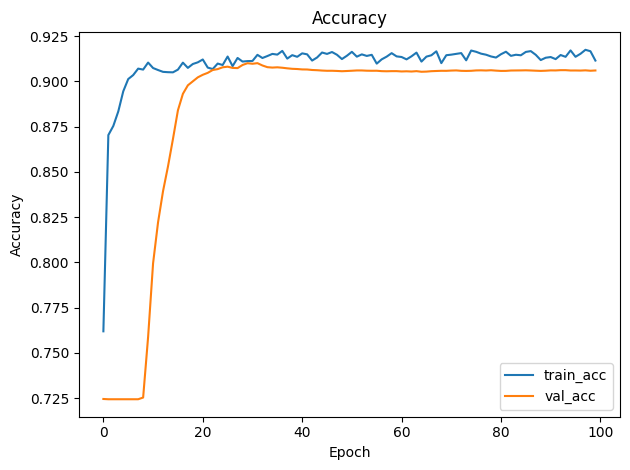

In [47]:
plot_accuracy_curves(nn_model_fit)

In [48]:
def plot_losses_curves(model):
    plt.figure()
    plt.plot(model.history['loss'], label='train_loss')
    plt.plot(model.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

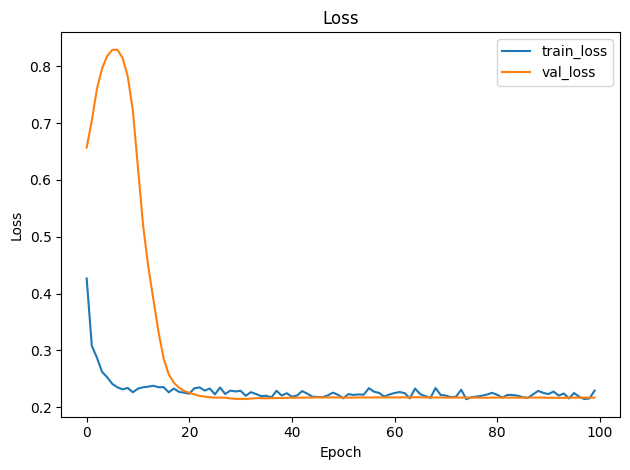

In [49]:
plot_losses_curves(nn_model_fit)

In [50]:
def plot_iou_curves(model):
    plt.figure()
    plt.plot(model.history['iou_metric'], label='IOU')
    plt.plot(model.history['val_iou_metric'], label='val_IOU')
    plt.title('IOU')
    plt.xlabel('Epochs')
    plt.ylabel('IOU Metric')
    plt.legend()
    plt.tight_layout()
    plt.show()

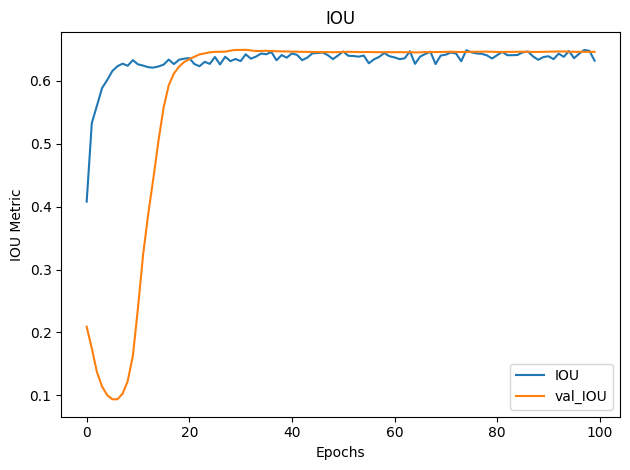

In [51]:
plot_iou_curves(nn_model_fit)

# Evaluate Model

In [52]:
def evaluate_model(model, X_test, y_test):
    loss, accuracy, iou = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")
    print(f"Test IoU: {iou}")

    # Custom metrics for water class
    y_pred = model.predict(X_test)
    y_pred_bin = (y_pred > 0.5).astype(np.float32)

    intersection = np.sum(y_test * y_pred_bin)
    union = np.sum(y_test) + np.sum(y_pred_bin) - intersection
    iou_water = intersection / union if union != 0 else 0

    precision = intersection / np.sum(y_pred_bin) if np.sum(y_pred_bin) != 0 else 0
    recall = intersection / np.sum(y_test) if np.sum(y_test) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    print(f"Water IoU: {iou_water}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

In [53]:
evaluate_model(nn_model, X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.9066 - iou_metric: 0.6339 - loss: 0.2249
Test Loss: 0.2170311063528061
Test Accuracy: 0.9060582518577576
Test IoU: 0.6456869840621948
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 638ms/step
Water IoU: 0.7247066497802734
Precision: 0.7902619242668152
Recall: 0.8972911238670349
F1-Score: 0.8403824721300974


# Visualize Predictions

In [54]:
def visualize_predictions(model, X_test, y_test, num_samples=3):
    # Select random indices
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    # Predict on the selected random samples
    y_pred = model.predict(X_test[indices])
    y_pred_bin = (y_pred > 0.5).astype(np.float32)

    for i in range(num_samples):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Show RGB approximation (bands 3,2,1 for Red,Green,Blue)
        # Use the original index from the random selection
        rgb = X_test[indices[i]][:, :, [3, 2, 1]]  # Adjust if band indices differ
        rgb = np.clip(rgb, 0, 1)  # Since normalized
        axs[0].imshow(rgb)
        axs[0].set_title('Input Image (RGB approx)')
        axs[0].axis('off')

        # Use the original index from the random selection
        axs[1].imshow(y_test[indices[i]].squeeze(), cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')

        # Use the prediction for the corresponding random index
        axs[2].imshow(y_pred_bin[i].squeeze(), cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')

        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


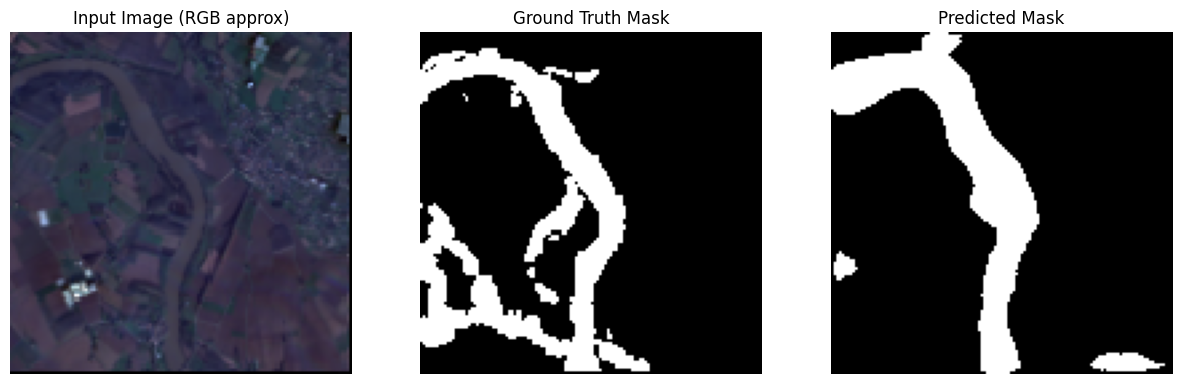

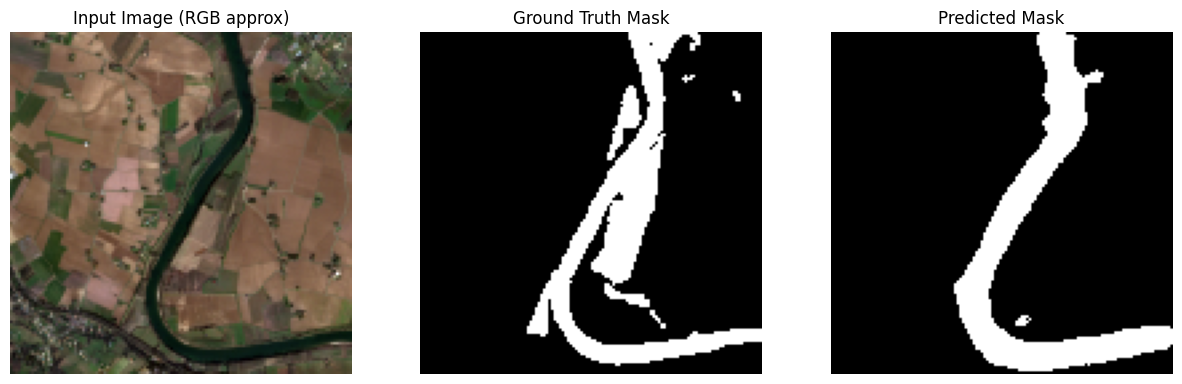

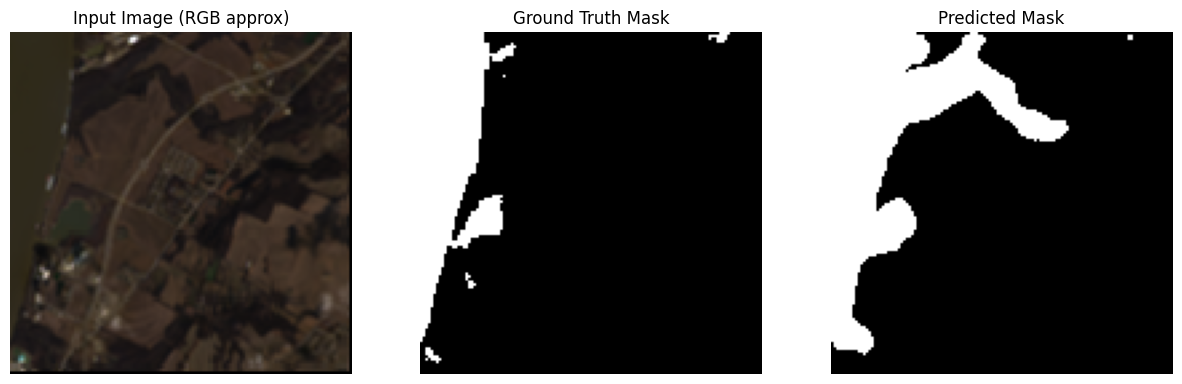

In [63]:
visualize_predictions(nn_model, X_test, y_test)

In [56]:
def visualize_predictions_blue(model, X_test, y_test, num_samples=3):
    # Select random indices
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    # Predict on the selected random samples
    y_pred = model.predict(X_test[indices])
    y_pred_bin = (y_pred > 0.5).astype(np.float32)

    for i in range(num_samples):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Show RGB approximation (bands 3,2,1 for Red,Green,Blue)
        # Use the original index from the random selection
        rgb = X_test[indices[i]][:, :, [3, 2, 1]]  # Adjust if band indices differ
        rgb = np.clip(rgb, 0, 1)  # Since normalized
        axs[0].imshow(rgb)
        axs[0].set_title('Input Image (RGB approx)')
        axs[0].axis('off')

        # Color ground truth mask: blue for water, black for non-water
        # Use the original index from the random selection
        gt_mask_colored = np.zeros((*y_test[indices[i]].shape[:-1], 3))
        gt_mask_colored[y_test[indices[i]].squeeze() == 1] = [0, 0, 1]  # Blue RGB for water
        axs[1].imshow(gt_mask_colored)
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')

        # Color predicted mask: blue for water, black for non-water
        # Use the prediction for the corresponding random index
        pred_mask_colored = np.zeros((*y_pred_bin[i].shape[:-1], 3))
        pred_mask_colored[y_pred_bin[i].squeeze() == 1] = [0, 0, 1]  # Blue RGB for water
        axs[2].imshow(pred_mask_colored)
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')

        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


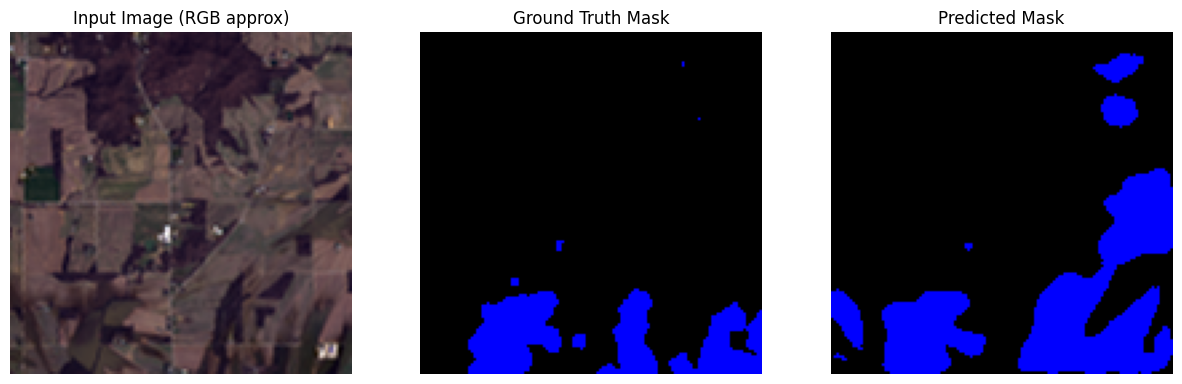

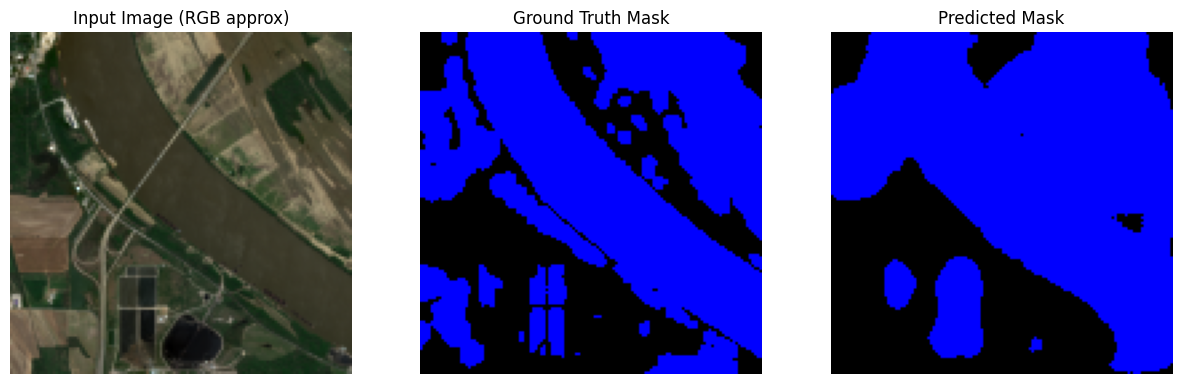

In [57]:
visualize_predictions_blue(nn_model, X_test, y_test, 2)



---





---



# Another Model with loss = binary_crossentropy instead of dice

In [75]:
nn_model_2 = unet_model(input_size=(128, 128, 12))
nn_model_2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_54[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_55[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ activation_56[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_57[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 46,779,265 (178.45 MB)

 Trainable params: 46,761,601 (178.38 MB)

 Non-trainable params: 17,664 (69.00 KB)

In [76]:
# Define callbacks
nn_model_2_callbacks = [
    # ModelCheckpoint to save the best model based on validation IoU
    ModelCheckpoint('best_unet_model_2.keras', monitor='val_iou_metric', save_best_only=True, mode='max', verbose=1),

    # ReduceLROnPlateau to reduce learning rate when validation IoU plateaus
    ReduceLROnPlateau(monitor='val_iou_metric',
                      factor=0.3, # Factor by which the learning rate will be reduced. new_lr = lr * factor
                      patience=2, # Number of epochs with no improvement after which the learning rate will be reduced.
                      mode='max',
                      min_lr=0.00000001, # Lower bound on the learning rate (1e-8).
                      verbose=1)
]

In [77]:
nn_model_2.compile(optimizer=Adam(learning_rate=LR),
                 loss='binary_crossentropy',
                 metrics=['accuracy', iou_metric])

### Delete existing model file if it exists

In [78]:
output_path = '/kaggle/working/best_unet_model_2.keras'
if os.path.exists(output_path):
    os.remove(output_path)
    print(f"Deleted existing file: {output_path}")
else:
    print(f"No existing file found at: {output_path}")

No existing file found at: /kaggle/working/best_unet_model_2.keras


In [79]:
print("Model is Fitting...")

nn_model_2_fit = nn_model_2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = nn_model_2_callbacks,
    # class_weight=class_weights
)

Model is Fitting...
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6681 - iou_metric: 0.3083 - loss: 0.6016   
Epoch 1: val_iou_metric improved from -inf to 0.22104, saving model to best_unet_model_2.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6729 - iou_metric: 0.3109 - loss: 0.5962 - val_accuracy: 0.8070 - val_iou_metric: 0.2210 - val_loss: 0.6560 - learning_rate: 1.0000e-04
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.8957 - iou_metric: 0.4842 - loss: 0.2927
Epoch 2: val_iou_metric did not improve from 0.22104
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 777ms/step - accuracy: 0.8959 - iou_metric: 0.4847 - loss: 0.2921 - val_accuracy: 0.7558 - val_iou_metric: 0.2128 - val_loss: 0.5982 - learning_rate: 1.0000e-04
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.9114 - iou_metric: 0.5371 - loss: 0.2460
Epoch 3: val_iou_metric did not improve from 0.22104

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-

## Notes:

* It peaked at epoch 32 with `val_iou_metric` = **0.6342**, `min lr` = **1e-8** with `accuracy` of **93.6%** and `val_accuracy` of **92.7%**

# Curves

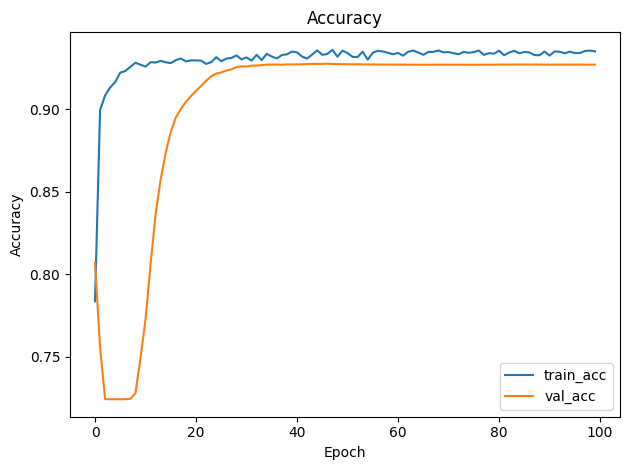

In [80]:
plot_accuracy_curves(nn_model_2_fit)

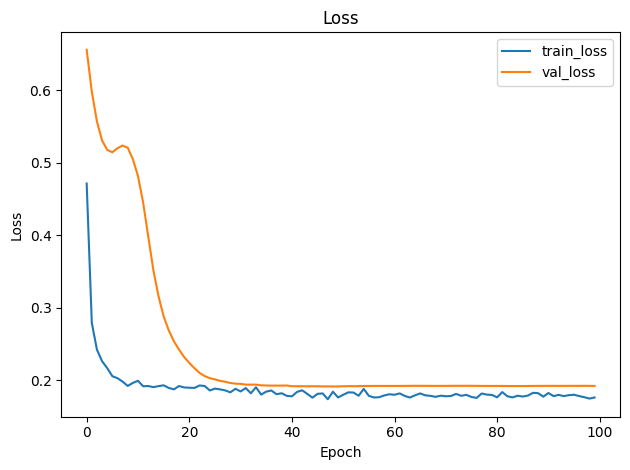

In [81]:
plot_losses_curves(nn_model_2_fit)

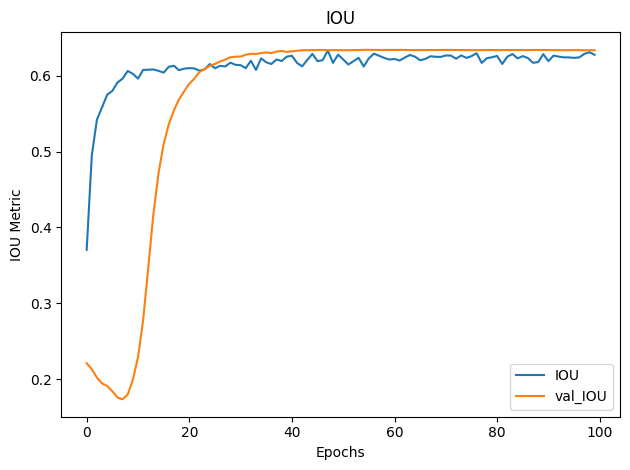

In [82]:
plot_iou_curves(nn_model_2_fit)

# Evaluations and Visuals

In [83]:
evaluate_model(nn_model_2, X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.9272 - iou_metric: 0.6184 - loss: 0.1947
Test Loss: 0.19228151440620422
Test Accuracy: 0.9270586967468262
Test IoU: 0.6336398720741272
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 613ms/step
Water IoU: 0.7605634927749634
Precision: 0.8886587619781494
Recall: 0.8406729102134705
F1-Score: 0.8640000204043846


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


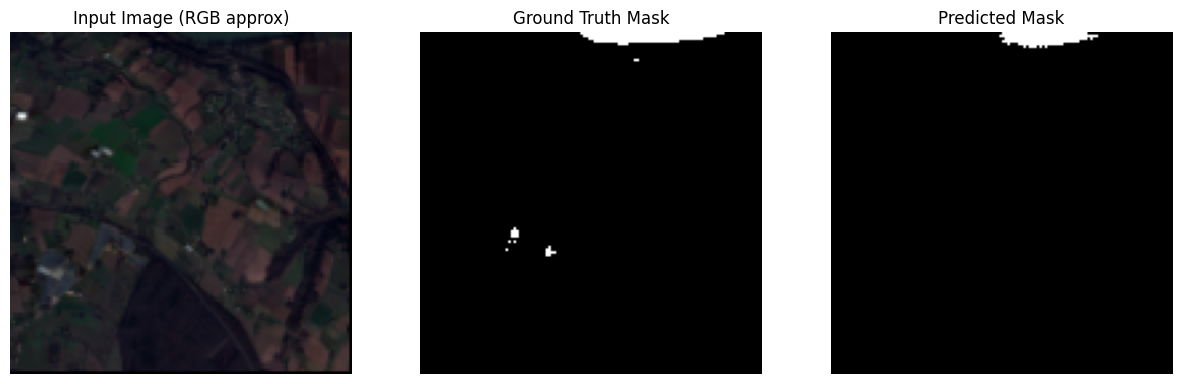

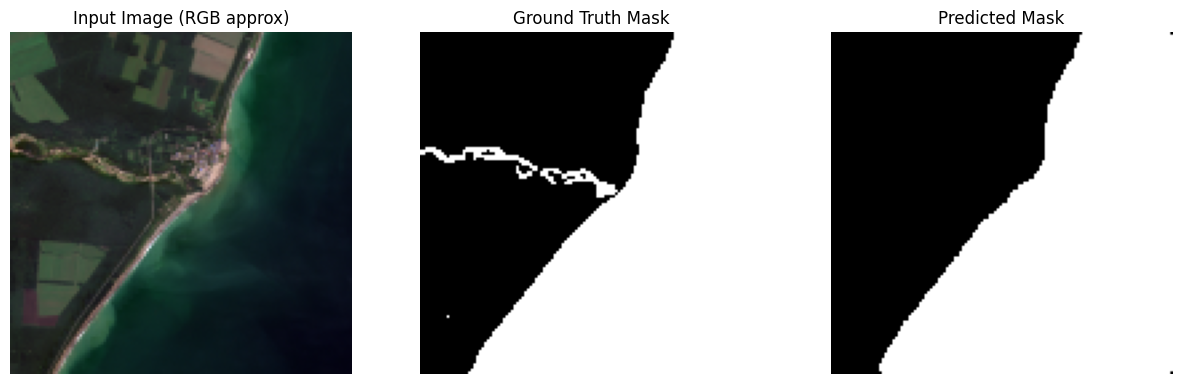

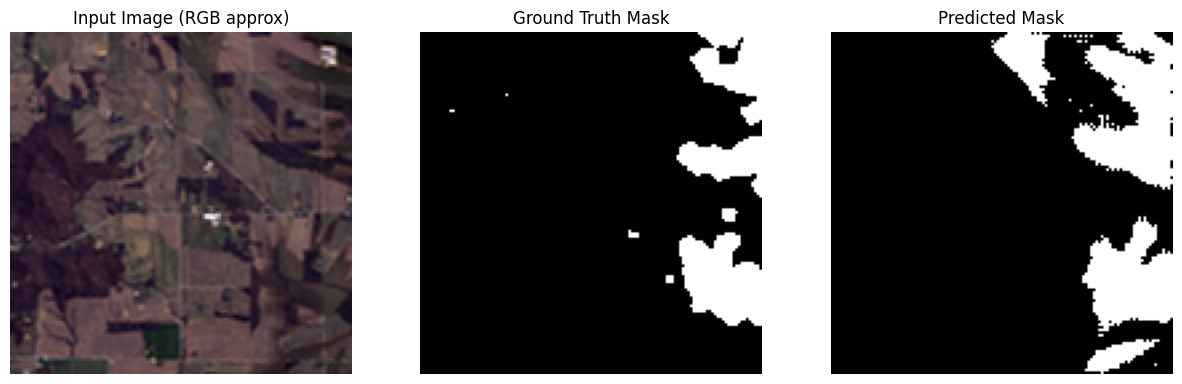

In [84]:
visualize_predictions(nn_model_2, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


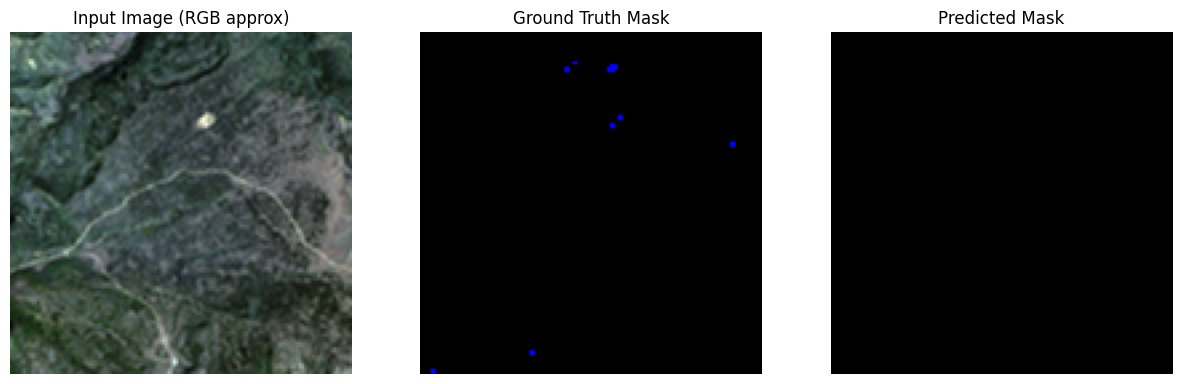

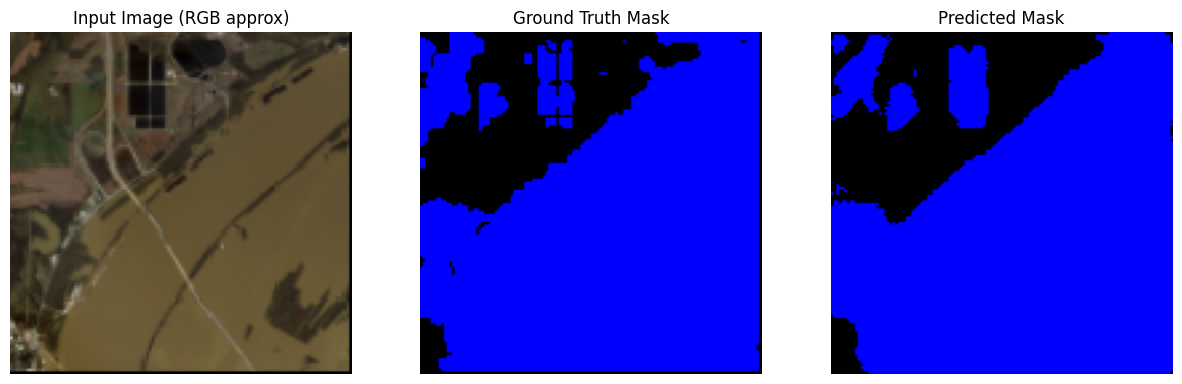

In [91]:
visualize_predictions_blue(nn_model_2, X_test, y_test, 2)

___

___